*Quick note: make sure you have the following packages installed before using this notebook!*

In [2]:
from astropy.stats import LombScargle # for periodograms
import corner # for visualizing parameter distributions
import numpy as np # for math and data storage
import pandas as pd # for math and data storage
import matplotlib.pyplot as plt # for plot making
import radvel # for fitting RVs
from radvel.plot import orbit_plots, mcmc_plots # for visualizing RVs
from scipy import optimize # for fitting RVs

# this bit below is just to fix an issue with radvel that appears if you're using numpy versions 1.22.0 or later!
try:
    np.__config__.blas_opt_info = np.__config__.blas_ilp64_opt_info
except Exception:
    pass

C:\Users\2189v\anaconda3\Lib\site-packages\radvel\gp.py:32: ImportWarning: celerite not installed. GP kernals using celerite will not work. Try installing celerite using 'pip install celerite'
  warnings.warn("celerite not installed. GP kernals using celerite will not work. \


# Finding the Orbital Parameters of ???

Welcome to the Radial Velocities assignment! In this assignment, you're going to be finding the mass (or minimum mass) of a planet from radial velocity measurements from scratch, all on your own.

This is a very open-ended assignment, and I'd like you to code it all on your own! You pick the planet, you code it up. That said, I will give some steps (that you don't have to follow but may be helpful):

1. Figure out which planet you want to find the orbital parameters of! Not all RV data is good to work with, especially for people still getting used to RVs. Ideally, you find a planet that:
- is the only planet in its system (otherwise you'll have two signals! You can model them both if you want a challenge, but you don't need to here.)
- is a very massive planet! If you have Earthike planets, the signals start getting too small for RV methods to detect without also having to model things like stellar variability (and trust me -- as someone who struggles to do that as a job, it's tough!)
- Around a Sun-like star (really small stars have very high signal semi-amplitudes but have a lot of stellar variability, while really big stars have very small RV semi-amplitudes!
- Has RVs from only one instrument, as each instrument may have different offsets or quirks that make them more difficult to model together
- Has RVs you can easily download and access yourself!

  Here are a few papers containing RVs that satisfy those bullet points! You don't need to use them, but they're here if you'd rather not find a system yourself.
- TrES-2 b, with its paper [here](https://iopscience.iop.org/article/10.1086/509123/pdf)
- HAT-P-15 b, with its paper [here](https://iopscience.iop.org/article/10.1088/0004-637X/724/2/866)
- HD 22532 b, with its paper [here](https://www.aanda.org/articles/aa/full_html/2022/01/aa40078-20/aa40078-20.html)

2. Download and read in the data! In some papers (like the HAT-P-15 b paper or the HD 22532 paper), the RVs are available in a downloadable table in the paper. Sometimes, the data is linked through data centers like CDS, or maybe Simbad or Vizier; sometimes, like in the TrES-2 b paper, you just need to copy and paste the table into a .txt file :/ In any case, get the data and read it in. To make sure you know it works, maybe try plotting your RVs as a function of time, with error bars if you can!

3. Figure out your priors! Some of these are going to be informed by realistic numbers (e.g. informing that your jitter cannot be negative), while some of these are going to be informed by previous studies. For example, if the paper you're getting your RV data from notes that this planet is transiting, use priors informed by the transits for $P$ and $t_0$! (RVs can figure out those two values to the tune of hours or minutes, but transits can get so much more precise values for those -- down to a fraction of a second in some cases -- that it's worth just using the values of $P$ and $t_0$ from transit fits for your priors.)

4. Figure out what values to initialize your parameters to. It's okay to just do this by eye if you don't have better options, but if you have better options use them! For example, it might be worth making your own peridogram to figure out what value to initialize your planet's period to if you don't have transit data.

5. Run a simple optimization fit!

6. Do an MCMC fit.

7. Look at your results! Do they look reasonable? Are they consistent with the results found in the papers you got data from?

In [3]:
# TODO: find planet masses!

### Part 1: Getting Our Data

In [4]:
df=pd.read_csv("TrES_2_RV.csv")

In [5]:
df.head()

,Observation Epoch (HJD - 2400000),Radial Velocity (m/s),σRV (m/s)
0,53949.76054,135.5,6.1
1,53949.91993,96.8,6.1
2,53950.00216,58.9,7.7
3,53950.79018,201.0,8.1
4,53950.93491,204.8,9.0


In [6]:
df.shape

(11, 3)

Text(0, 0.5, 'Radial Velocity (m/s)')

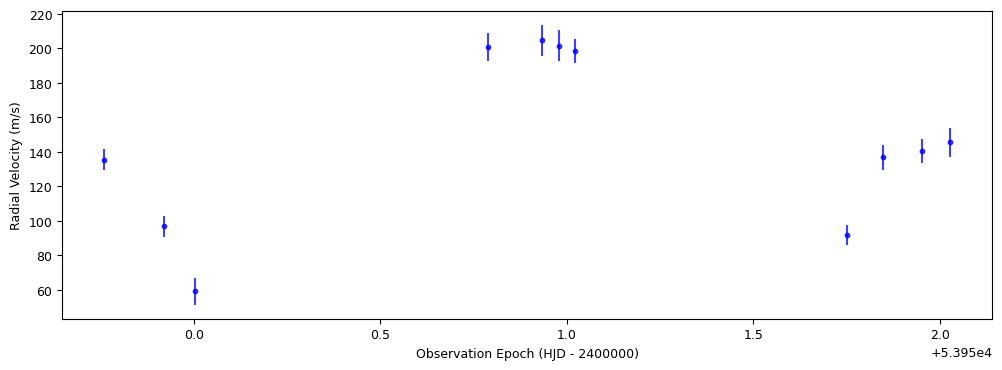

In [7]:
fig, ax = plt.subplots(figsize = (12, 4))
ax.scatter(df['Observation Epoch (HJD - 2400000)'], df['Radial Velocity (m/s)'], s = 10, color = 'blue', alpha = 0.75)
ax.errorbar(x = df['Observation Epoch (HJD - 2400000)'], y = df['Radial Velocity (m/s)'], yerr = df['σRV (m/s)'], color = 'blue', alpha = 0.75, ls = 'None')
ax.set_xlabel("Observation Epoch (HJD - 2400000)")
ax.set_ylabel("Radial Velocity (m/s)")

### Part 2: Identifying Signals

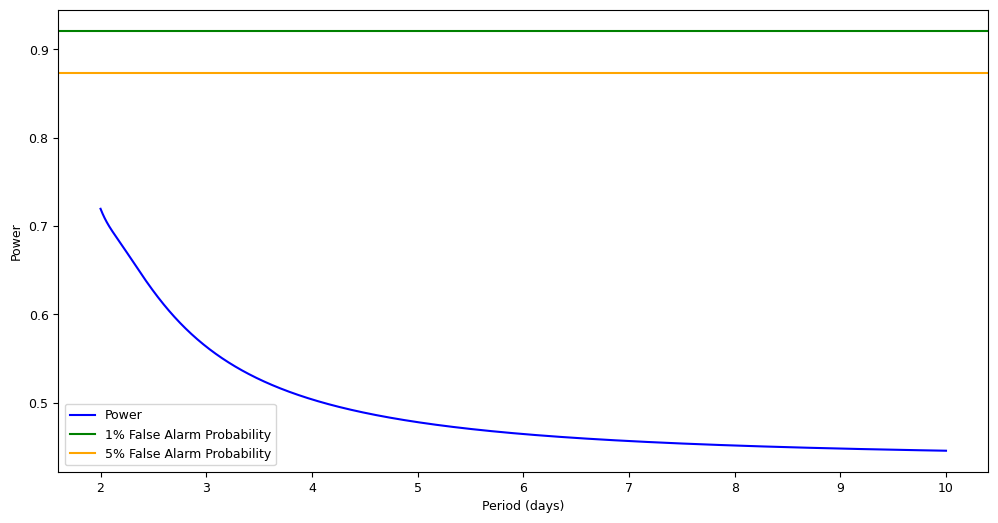

In [8]:
periods = np.logspace(np.log10(2.), np.log10(10.), num = 1000)
frequency = 1. / periods
ls = LombScargle(df['Observation Epoch (HJD - 2400000)'], df['Radial Velocity (m/s)'], df['σRV (m/s)'], fit_mean = True)
power = ls.power(frequency)

fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(periods, power, label = 'Power', c = 'blue')
ax.set_xlabel("Period (days)")
ax.set_ylabel("Power")

ax.axhline(xmin = 0, xmax = 1, y = ls.false_alarm_level([0.01]), c = 'green',  label = '1% False Alarm Probability')
ax.axhline(xmin = 0, xmax = 1, y = ls.false_alarm_level([0.05]), c = 'orange', label = '5% False Alarm Probability')

ax.legend();

In [9]:
best_period = periods[np.argmax(power)]
print(f"Best period is {best_period:.3f} days.")

Best period is 2.000 days.


### Part 3: Creating Our Model

In [10]:
def initialize_model():
    
    params = radvel.Parameters(1,basis='per tc secosw sesinw k')
    params['per1'] = radvel.Parameter(value=best_period)       # Insert our guess for period of first planet (from periodogram)
    params['tc1'] = radvel.Parameter(value=2.0)      # guess for time of transit of 1st planet
    params['secosw1'] = radvel.Parameter(value=0.001)    # determines eccentricity (assuming circular orbit here)
    params['sesinw1'] = radvel.Parameter(value=0.001)    # determines eccentriciy (assuming circular orbit here)
    params['k1'] = radvel.Parameter(value=70.)          # radial velocity semi-amplitude
    
    params['dvdt'] = radvel.Parameter(value=0., vary = False) # possible acceleration of star
    params['curv'] = radvel.Parameter(value=0., vary = False)  # possible curvature in long-term radial velocity trend
    mod = radvel.RVModel(params)
    
    return mod

In [11]:
mod = initialize_model() # model initiliazed
like = radvel.likelihood.RVLikelihood(mod, df['Observation Epoch (HJD - 2400000)'], df['Radial Velocity (m/s)'], df['σRV (m/s)']) # initialize Likelihood object

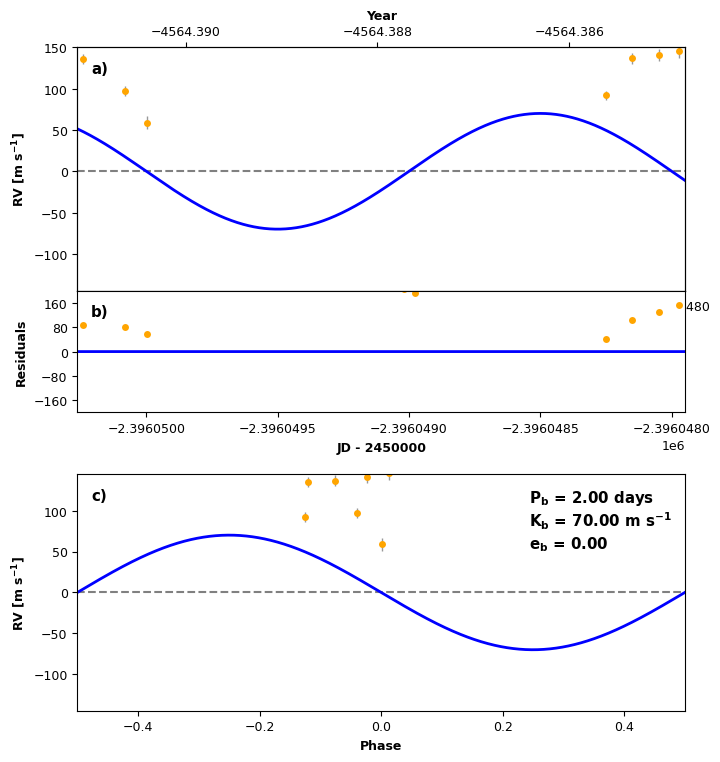

In [12]:
post = radvel.posterior.Posterior(like) # initialize radvel.Posterior object

RVPlot = orbit_plots.MultipanelPlot(post, legend = False)
RVPlot.plot_multipanel();

In [13]:
print(like)

parameter                     value      vary
per1                              2       True
tc1                               2       True
secosw1                       0.001       True
sesinw1                       0.001       True
k1                               70       True
dvdt                              0      False
curv                              0      False
gamma                             0       True
jit                               0       True
tp1                            1.75           
e1                            2e-06           
w1                         0.785398           



In [14]:
res = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',           # Nelder-Mead also works
    )
print(post)

parameter                     value      vary
per1                         1.0097       True
tc1                         3.06323       True
secosw1                    -0.27577       True
sesinw1                   -0.547746       True
k1                          184.226       True
dvdt                              0      False
curv                              0      False
gamma                       20.2188       True
jit                         45.5567       True
tp1                         3.42117           
e1                         0.376075           
w1                         -2.03721           

Priors
------



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


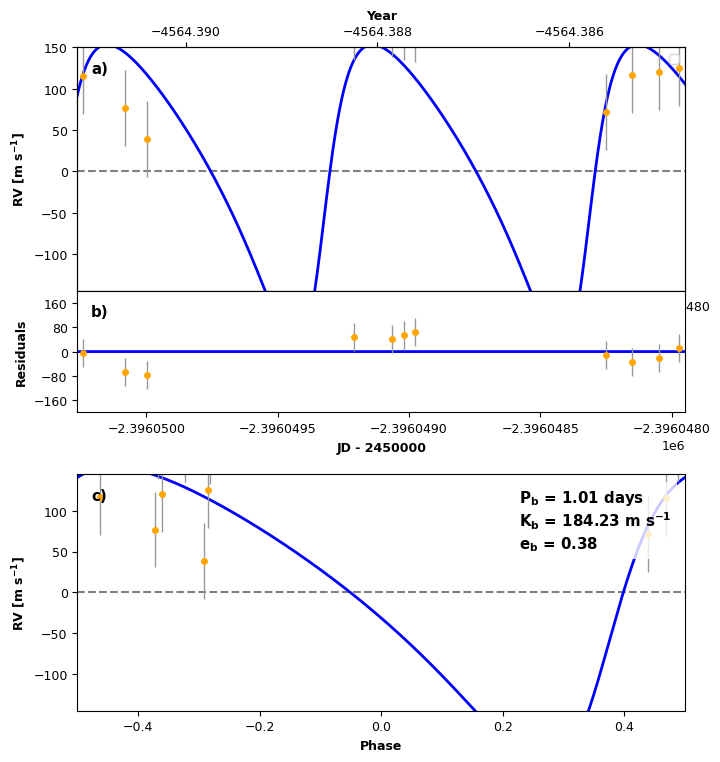

In [15]:
RVPlot = orbit_plots.MultipanelPlot(post)
RVPlot.plot_multipanel();

### Part 4: MCMC Fitting

In [16]:
post = radvel.posterior.Posterior(like)
post.priors += [radvel.prior.HardBounds('jit', 0., 100.)]

In [ ]:
df = radvel.mcmc(post, nwalkers=64, nrun=10000, burnAfactor=100, burnGR=1.01)

256000/5120000 (5.0%) steps complete; Running 3180.91 steps/s; Mean acceptance rate = 19.1%; Min Auto Factor =  25; Max Auto Relative-Change =   inf; Min Tz = 11617.0; Max G-R = 1.002
Discarding burn-in now that the chains are marginally well-mixed



df = radvel.mcmc(post, nwalkers=64, nrun=10000)

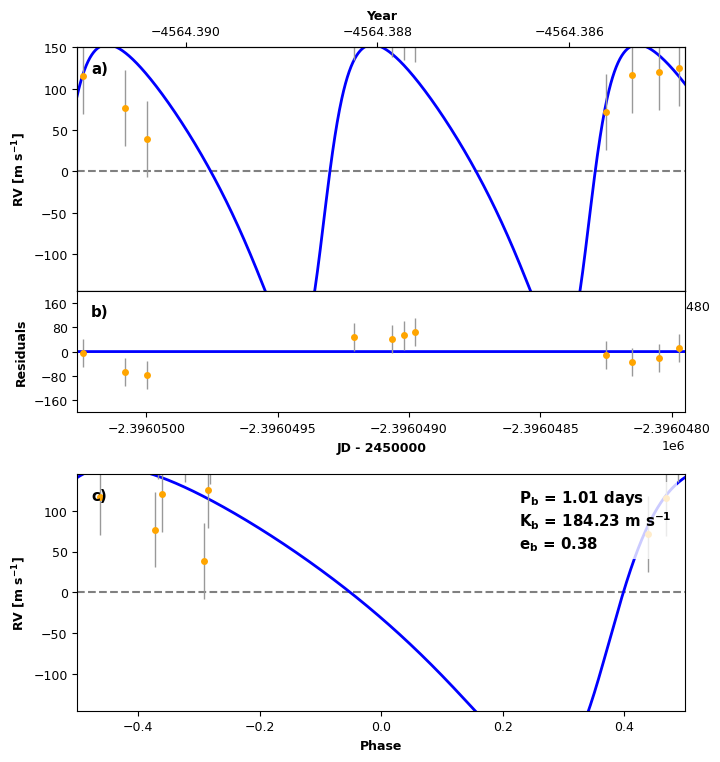

In [17]:
RVPlot = orbit_plots.MultipanelPlot(post, legend = False)
RVPlot.plot_multipanel();

In [18]:
Corner = mcmc_plots.CornerPlot(post, df)
Corner.plot()

KeyError: "None of [Index(['per1', 'tc1', 'secosw1', 'sesinw1', 'k1', 'gamma', 'jit'], dtype='object')] are in the [columns]"

In [19]:
def planetary_mass(K, P, M_star):
    '''
    Given a semi-amplitude (in m/s), a period (in days), and a stellar mass (in solar masses),
    returns the mass of the planet that caused that signal (in Earth masses).
    '''
    
    return (1. / 0.647204) * K * np.power(M_star, 2/3) * np.power(P, 1/3)


planetary_mass(57.92, 4.23, 1.12)

156.09158766998203